In [2]:
import os
import glob

import pandas as pd
import numpy as np

import cv2

import matplotlib.pyplot as plt

## 1. Load Txt Log

In [3]:
def read_log(test_file):
    columns_labels = ['DateTime','SearchMap','Tag','FileName', 'MsgType', 'BufferLength', 'Focus', 'MapId', 'Pose', 'LocalizationFlag']
    df = pd.DataFrame([],index=[],
               columns=columns_labels)
    idx = 0
    with open(test_file, 'r') as file_to_read:
        while True:
            lines = file_to_read.readline()
            if not lines:
                break
            time = lines[0:19]
            flag = lines[22:34]
            
            # received a new localization requirement
            if(flag == "receive data"):
                idx += 1
                Message = [None for i in range(len(columns_labels))]
                id_tag = lines.find("_tag")
                id_msgType = lines.find("_msgType")
                id_imgsize = lines.find("_imgSize")
                id_param = lines.find("param")
                tag = lines[id_tag+6: id_msgType-1]
                msgType = lines[id_msgType+9: id_imgsize-1]
                imagesize = lines[id_imgsize+9: id_param-2]
                #print(flag, tag, msgType, imagesize)
                
                id_focus = lines.find("focus=")
                focus = lines[id_focus+6: id_focus+8+9]
                
                id_mapid = lines.find("mapId=")
                #mapid_flag = lines[id_mapid+6: id_mapid+7]
                
                Message[0] = time
                Message[2] = tag
                
                if(tag[0:3] == "ios"):
                    image_file = tag + ".jpg"
                else:
                    image_file = tag + ".YUV"
                    
                Message[3] = image_file
                Message[4] = msgType
                Message[5] = int(imagesize)
                Message[6] = float(focus)   
                
                if(lines[id_mapid+6: id_mapid+7] == "," or lines[id_mapid+6: id_mapid+10] == "null"):
                    # ask for the map search
                    lines_s = file_to_read.readline() # should be start search map
                    lines_s = file_to_read.readline() # should be end search map
                    if not lines_s:
                        break
                    id_mapsearchid = lines_s.find("_mapList:")
                    map_search_result = lines_s[id_mapsearchid+10: id_mapsearchid+12]
                    #print(map_search_result)
                    if(map_search_result == "[]"):
                        # search map failed -> move on to next line
                        Message[1] = "Fail"
                    else:
                        Message[1] = "Success"
                else:
                    Message[1] = "FromInput"
                    
                if(Message[1] == "Fail"):
                    df.loc[idx]= Message
                    Message[9] = 'Fail'
                    continue;
                    
                lines_mapid = file_to_read.readline() # should be start location map
                id_mapsearchid = lines_mapid.find("_mapId :")
                Message[7] = lines_mapid[id_mapsearchid+9: -1] 
                
                lines_pose = file_to_read.readline() # should be end location map
                id_pose = lines_pose.find("position=")
                id_mapid = lines_pose.find(", mapId=")
                #print(lines_pose)
                #print(Message[1], lines_pose[id_pose+10:id_mapid-1])
                pose = (lines_pose[id_pose+10:id_mapid-1]).split(',')
                pose = np.asarray(pose, np.float)
                Message[8] = pose
                if(np.sum(pose) == 0):
                    Message[9] = 'Fail'
                else:
                    Message[9] = 'Success'
                
                
                df.loc[idx]= Message
    return df

In [4]:
test_file = "ios-2317e031-13-53/location_log.txt"
df = read_log(test_file)
df.head()

,DateTime,SearchMap,Tag,FileName,MsgType,BufferLength,Focus,MapId,Pose,LocalizationFlag
1,2020-08-12 13:53:11,Fail,ios_1,ios_1.jpg,301,4250,522.217468,None,None,None
2,2020-08-12 13:53:19,Success,ios_2,ios_2.jpg,301,22007,523.052368,e69a4123-d89f-11ea-9cb1-da42307ea98d,"[0.496057, 0.019977, 0.86806, 0.0, -0.004627, ...",Success
3,2020-08-12 13:53:27,FromInput,ios_3,ios_3.jpg,301,19285,515.538086,e69a4123-d89f-11ea-9cb1-da42307ea98d,"[0.486308, 0.006269, 0.873765, 0.0, 0.001378, ...",Success
4,2020-08-12 13:53:35,FromInput,ios_4,ios_4.jpg,301,18177,525.139648,e69a4123-d89f-11ea-9cb1-da42307ea98d,"[0.524659, -0.117385, 0.843181, 0.0, -0.045336...",Success
5,2020-08-12 13:53:48,FromInput,ios_5,ios_5.jpg,301,27908,523.469849,e69a4123-d89f-11ea-9cb1-da42307ea98d,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Fail


In [5]:
test_file = "android-90066be6-14-42/location_log.txt"
df = read_log(test_file)
df.head()

,DateTime,SearchMap,Tag,FileName,MsgType,BufferLength,Focus,MapId,Pose,LocalizationFlag
1,2020-08-12 14:42:58,Success,android_1,android_1.YUV,301,307200,498.02417,e69a4123-d89f-11ea-9cb1-da42307ea98d,"[0.438228, 0.046195, 0.897676, 0.0, -0.002198,...",Success
2,2020-08-12 14:43:13,FromInput,android_2,android_2.YUV,301,307200,498.02417,e69a4123-d89f-11ea-9cb1-da42307ea98d,"[-0.092777, -0.137731, 0.986115, 0.0, -0.01022...",Success
3,2020-08-12 14:43:32,FromInput,android_3,android_3.YUV,301,307200,498.02417,e69a4123-d89f-11ea-9cb1-da42307ea98d,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Fail
4,2020-08-12 14:43:57,FromInput,android_4,android_4.YUV,301,307200,498.02417,e69a4123-d89f-11ea-9cb1-da42307ea98d,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Fail
5,2020-08-12 14:44:13,FromInput,android_5,android_5.YUV,301,307200,498.02417,e69a4123-d89f-11ea-9cb1-da42307ea98d,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Fail


## 2. Analysis Android results

In [6]:
def load_image_scan(file):
    #print(file,file[-3:] )
    if file[-3:] == "YUV":
        scan = np.fromfile(file, dtype=np.uint8).reshape((480,640))
    elif file[-3:] == "jpg":
        scan = cv2.imread(file)
    return scan

In [18]:
def AnalysisLocalizationResult(log_folder):
    test_file = log_folder + "/location_log.txt"
    df = read_log(test_file)
    print("------ Read", df.shape[0], "instance(s), from folder",log_folder,"------")
    
    n_search = df.shape[0] - np.sum(df['SearchMap'] == 'FromInput')
    print("Map Search : Process", n_search, "time(s).")
    
    n_fail = np.sum(df['LocalizationFlag'] == 'Fail')
    n_succ = np.sum(df['LocalizationFlag'] == 'Success')
    print("Localization : Total Success Rate is", n_succ/df.shape[0], " [",n_succ,"/",df.shape[0],"]")

    failed_images = df['FileName'][df['LocalizationFlag'] == 'Fail']
    i = 0
    
    while(i < len(failed_images.values)):
        image_path = failed_images.values[i]
        focus = df['Focus'][failed_images.index[i]]
        image_path_full = log_folder + "/data/" + image_path
        #print(image_path_full)
        image = load_image_scan(image_path_full)
        image = cv2.putText(image, image_path+" "+str(focus)[0:5], (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        cv2.imshow("Failed Image Show", image)
        key = cv2.waitKey(10)
        if key == ord('d'): 
            i += 1
        elif key == ord('a'): 
            i -= 1
            i = max(i,0)
        elif key == ord('q'):
            break
    cv2.destroyAllWindows()

In [19]:
android_log_folders = glob.glob("android*")
for i in range(len(android_log_folders)):
    AnalysisLocalizationResult(android_log_folders[i])

------ Read 84 instance(s), from folder android-ec3161d8-15-46 ------
Map Search : Process 1 time(s).
Localization : Total Success Rate is 0.4642857142857143  [ 39 / 84 ]
------ Read 94 instance(s), from folder android-8183a6f1-14-18 ------
Map Search : Process 1 time(s).
Localization : Total Success Rate is 0.48936170212765956  [ 46 / 94 ]
------ Read 73 instance(s), from folder android-90066be6-14-42 ------
Map Search : Process 1 time(s).
Localization : Total Success Rate is 0.4246575342465753  [ 31 / 73 ]


In [20]:
ios_log_folders = glob.glob("ios*")
for i in range(len(ios_log_folders)):
    AnalysisLocalizationResult(ios_log_folders[i])

------ Read 99 instance(s), from folder ios-2317e031-13-53 ------
Map Search : Process 6 time(s).
Localization : Total Success Rate is 0.5757575757575758  [ 57 / 99 ]
------ Read 70 instance(s), from folder ios-e36d3ae6-15-20 ------
Map Search : Process 2 time(s).
Localization : Total Success Rate is 0.4714285714285714  [ 33 / 70 ]
------ Read 65 instance(s), from folder ios-962bdb1b-15-33 ------
Map Search : Process 2 time(s).
Localization : Total Success Rate is 0.5384615384615384  [ 35 / 65 ]


## 3. Save the failed images then analysis

In [40]:
def SaveFiledImages(log_folder, save_path, key):
    test_file = log_folder + "/location_log.txt"
    df = read_log(test_file)
    #print("------ Read", df.shape[0], "instance(s), from folder",log_folder,"------")
    failed_images = df['FileName'][df['LocalizationFlag'] == 'Fail']
    i = 0
    
    while(i < len(failed_images.values)):
        image_path = failed_images.values[i]
        image_path_full = log_folder + "/data/" + image_path
        image = load_image_scan(image_path_full)
        cv2.imwrite(save_path + "/" + key +"_"+ str(i)+".png", image)
        i+=1
    #print(" saved", len(failed_images.values), "failed images")
    return len(failed_images.values)

In [59]:
!mkdir failed_images
!mkdir failed_images_debug

mkdir: cannot create directory ‘failed_images’: File exists


In [66]:
save_path = "failed_images"

android_log_folders = glob.glob("android*")
count = 0
for i in range(len(android_log_folders)):
    count += SaveFiledImages(android_log_folders[i], save_path, "android"+str(i))
ios_log_folders = glob.glob("ios*")
for i in range(len(ios_log_folders)):
    count += SaveFiledImages(ios_log_folders[i], save_path, "ios"+str(i))

print("Saved", count, "failed images.")

Saved 241 failed images.


#### localization test

Usage: ./example database_path sparse_map_path voc_indices_path test_images_path focus_length

./../tools_map/build/example /home/viki/Lucas/garden/garden_v2/database.db /home/viki/Lucas/garden/garden_v2/sparse /home/viki/Lucas/garden/garden_v2/VocIndex.bin failed_images/ 560

In [151]:
!./../tools_map/build/example /home/viki/Lucas/garden/garden_v2/database.db /home/viki/Lucas/garden/garden_v2/sparse /home/viki/Lucas/garden/garden_v2/VocIndex.bin failed_images/ failed_images_debug/ 560


 Test image from : failed_images/
   image focus length : 560
Test SIFT GPU extract features, then use Voc tree to find match image
Use Pnp and optimization method to esimate camera pose.
    --  Test Start


 [MAP INFO] sparse feature map  
            camera number : 1
            point number : 174385
            image number : 1258

 [VOC TREE]  Read indexs : 
             Calculating TF-IDF . 

 [MATCH GPU] create sift matcher gpu. 

 [START] input new image : ios1_20.png Count: 1
 [SUCCESS] Localization successed. 
 [FINISH]  Total time used : 0.62855

 [START] input new image : ios0_38.png Count: 2
 [FAIL] Localization failed. 
 [FINISH]  Total time used : 0.995681

 [START] input new image : android2_11.png Count: 3
 [SUCCESS] Localization successed. 
 [FINISH]  Total time used : 0.489335

 [START] input new image : android2_21.png Count: 4
 [FAIL] Localization failed. 
 [FINISH]  Total time used : 0.711905

 [START] input new image : ios0_35.png Count: 5
 [FAIL] Localization 

 [SUCCESS] Localization successed. 
 [FINISH]  Total time used : 0.490958

 [START] input new image : android1_27.png Count: 66
 [SUCCESS] Localization successed. 
 [FINISH]  Total time used : 0.405391

 [START] input new image : android0_27.png Count: 67
 [FAIL] Localization failed. 
 [FINISH]  Total time used : 0.500962

 [START] input new image : android1_35.png Count: 68
 [FAIL] Localization failed. 
 [FINISH]  Total time used : 0.838323

 [START] input new image : ios0_26.png Count: 69
 [FAIL] Localization failed. 
 [FINISH]  Total time used : 0.973013

 [START] input new image : android2_4.png Count: 70
 [SUCCESS] Localization successed. 
 [FINISH]  Total time used : 0.696463

 [START] input new image : android1_8.png Count: 71
 [FAIL] Localization failed. 
 [FINISH]  Total time used : 0.70297

 [START] input new image : android1_4.png Count: 72
 [FAIL] Localization failed. 
 [FINISH]  Total time used : 0.720715

 [START] input new image : android0_24.png Count: 73
 [FAIL] Locali

 [FAIL] Localization failed. 
 [FINISH]  Total time used : 0.937519

 [START] input new image : ios0_39.png Count: 134
 [FAIL] Localization failed. 
 [FINISH]  Total time used : 1.07842

 [START] input new image : ios0_23.png Count: 135
 [FAIL] Localization failed. 
 [FINISH]  Total time used : 1.11289

 [START] input new image : android0_33.png Count: 136
 [FAIL] Localization failed. 
 [FINISH]  Total time used : 0.565135

 [START] input new image : ios0_2.png Count: 137
 [FAIL] Localization failed. 
 [FINISH]  Total time used : 0.912439

 [START] input new image : ios2_9.png Count: 138
 [FAIL] Localization failed. 
 [FINISH]  Total time used : 0.88036

 [START] input new image : android1_30.png Count: 139
 [FAIL] Localization failed. 
 [FINISH]  Total time used : 0.718208

 [START] input new image : android1_12.png Count: 140
 [FAIL] Localization failed. 
 [FINISH]  Total time used : 0.720797

 [START] input new image : ios0_9.png Count: 141
 [FAIL] Localization failed. 
 [FINISH]  T

 [FAIL] Localization failed. 
 [FINISH]  Total time used : 4.3855

 [START] input new image : android2_0.png Count: 202
 [FAIL] Localization failed. 
 [FINISH]  Total time used : 0.701438

 [START] input new image : android0_42.png Count: 203
 [FAIL] Localization failed. 
 [FINISH]  Total time used : 0.50572

 [START] input new image : android2_17.png Count: 204
 [SUCCESS] Localization successed. 
 [FINISH]  Total time used : 0.587957

 [START] input new image : android1_26.png Count: 205
 [SUCCESS] Localization successed. 
 [FINISH]  Total time used : 0.613794

 [START] input new image : ios0_33.png Count: 206
 [FAIL] Localization failed. 
 [FINISH]  Total time used : 0.883945

 [START] input new image : android0_5.png Count: 207
 [SUCCESS] Localization successed. 
 [FINISH]  Total time used : 0.329667

 [START] input new image : android0_28.png Count: 208
 [FAIL] Localization failed. 
 [FINISH]  Total time used : 0.62613

 [START] input new image : android1_40.png Count: 209
 [SUCCES

## 4. Show debug images

In [71]:
debug_folder = "failed_images_debug/"
failed_image_folder = "failed_images/"

In [81]:
failed_images = glob.glob(failed_image_folder + "*")
failed_images.sort()
print("Load", len(failed_images), "test images")

Load 241 test images


In [149]:
def plot_debug_image(idx, failed_images, failed_image_folder, debug_folder):
    image = failed_images[idx]
    search_name = image[len(failed_image_folder):-4]
    debug_images = glob.glob(debug_folder + "/" + search_name + "_*")
    debug_images.sort()
    num = int(np.ceil(len(debug_images)/2))
    plt.figure(figsize=(20,70))
    total_img = len(debug_images)
    for i in range(total_img):
        plt.subplot(num*2, 1, (i+1))
        image_cv = cv2.imread(debug_images[i])
        b,g,r = cv2.split(image_cv)  
        image_cv = cv2.merge([r,g,b])  
        plt.imshow(image_cv)
        
def cvshow_debug_image(idx, failed_images, failed_image_folder, debug_folder):
    image = failed_images[idx]
    search_name = image[len(failed_image_folder):-4]
    debug_images = glob.glob(debug_folder + "/" + search_name + "_*")
    debug_images.sort()
    total_img = len(debug_images)
    i = 0
    while i < total_img:
        image_cv = cv2.imread(debug_images[i])
        cv2.imshow("Debug Image Show "+search_name, image_cv)
        key = cv2.waitKey(1)
        if key == ord('d'): 
            i += 1
        elif key == ord('a'): 
            i -= 1
            i = max(i,0)
        elif key == ord('q'):
            break
    cv2.destroyAllWindows()

In [153]:
for idx in range(len(failed_images)):
    cvshow_debug_image(idx, failed_images, failed_image_folder, debug_folder)

In [141]:
cv2.destroyAllWindows()

## 5. Simple Analysis

In [159]:
show_folder = "typical_ones"
show_images = glob.glob(show_folder + "/*")
show_images.sort()
# plt.figure(figsize = (15,40))
# for i in range(len(show_images)):
#     image_cv = cv2.imread(show_images[i])
#     b,g,r = cv2.split(image_cv)  
#     image_cv = cv2.merge([r,g,b])  
#     plt.subplot(len(show_images), 1 , (i+1))
#     plt.imshow(image_cv)

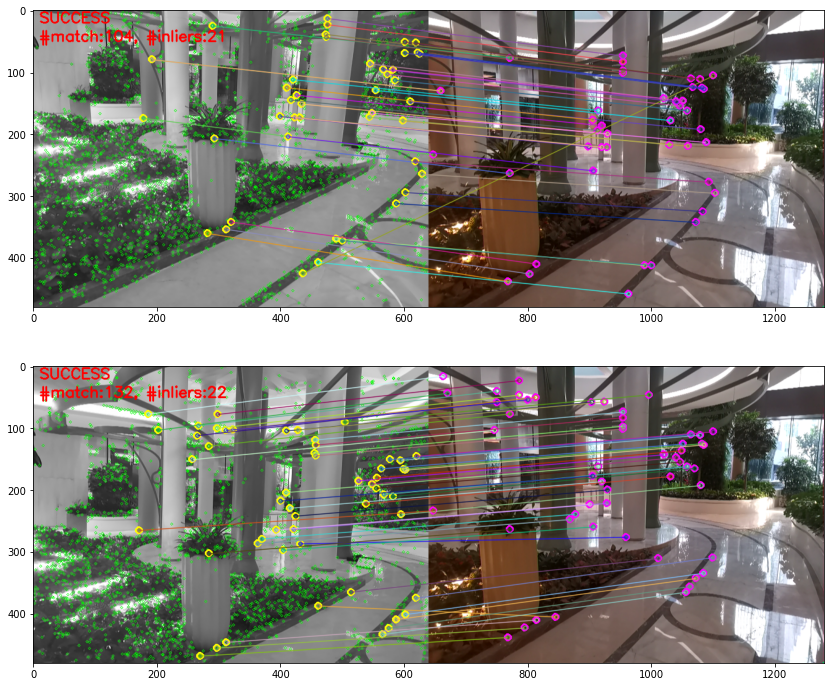

In [166]:
plt.figure(figsize = (15,12))
for i in range(2,4):
    image_cv = cv2.imread(show_images[i])
    b,g,r = cv2.split(image_cv)  
    image_cv = cv2.merge([r,g,b])  
    plt.subplot(2, 1 , (i-1))
    plt.imshow(image_cv)

**Problem** : Here are two success cases.  While we could see that , the features are all came from some too far or not remarkable places. While in the columns and in the planets, the algorithm could barely find any features.

**Key** : Lack of features.

**Solution** : Make more features.

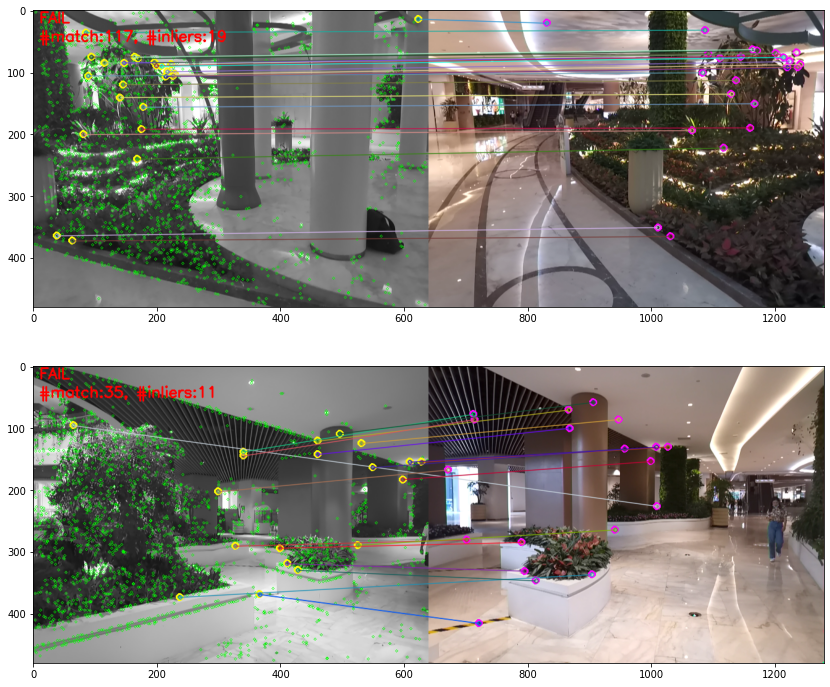

In [164]:
plt.figure(figsize = (15,12))
for i in range(2):
    image_cv = cv2.imread(show_images[i])
    b,g,r = cv2.split(image_cv)  
    image_cv = cv2.merge([r,g,b])  
    plt.subplot(2, 1 , (i+1))
    plt.imshow(image_cv)

**Problem** : The upper two images show the case, where we found the correct corresponding keyframes. And we even get some inliers, and could get a reasonable pose estimation. while, the final matches are too few, that we cannot use it as our final outputs.

**Key** : Lack of features.

**Solution** : Make more features.

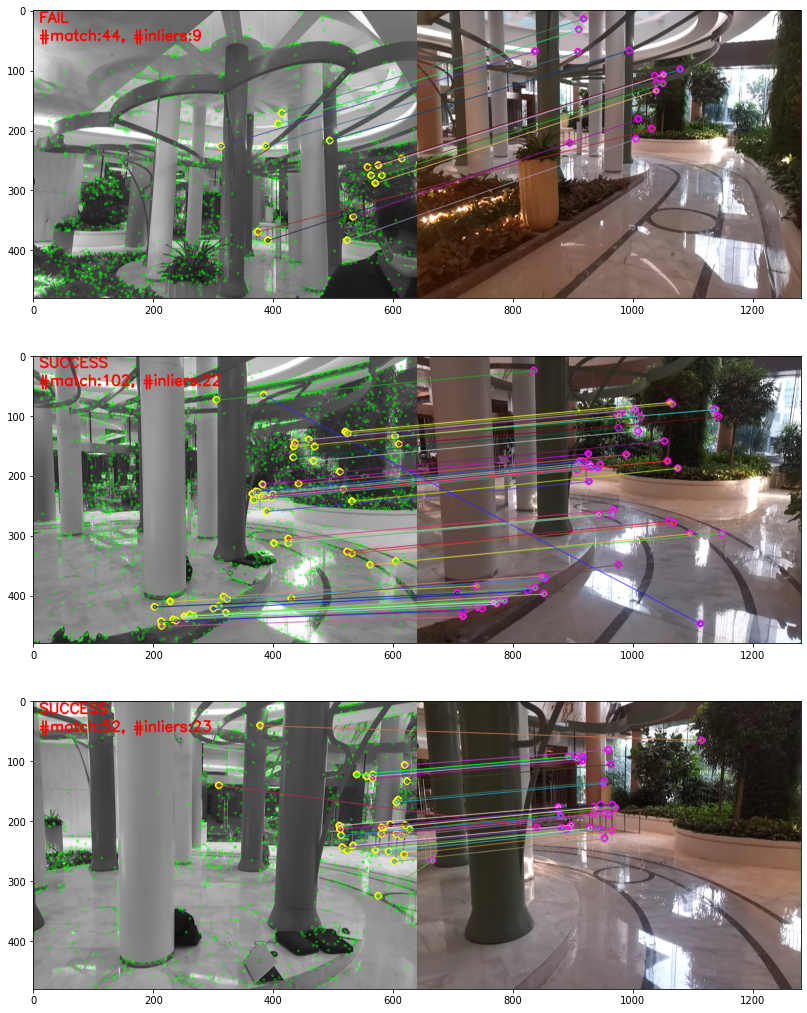

In [170]:
plt.figure(figsize = (15,18))
for i in range(4,7):
    image_cv = cv2.imread(show_images[i])
    b,g,r = cv2.split(image_cv)  
    image_cv = cv2.merge([r,g,b])  
    plt.subplot(3, 1 , (i-3))
    plt.imshow(image_cv)

**Problem** : Here we show some matches keyframe with a difficulty case. This scene lack useful feaures, make it match hard to match. Even we finally succeed, we could see that all the matched features are far and grouped in a corner, which will make the pose estimation extremely noisy.

**Key** : Lack of features.

**Solution** : Make more features.